# Fine-Tuning P.1203 Model

# ITU-T P.1203

In [191]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pq
from itu_p1203_new import P1203Pa
from itu_p1203_new import P1203Pv
from itertools import permutations

import json


In [192]:
f = open("./mode0-bothtests.json")
input_data = json.load(f)
input_data

{'I11': {'segments': [], 'streamId': 42},
 'I13': {'segments': [{'codec': 'h264',
    'start': 0,
    'duration': 5,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30},
   {'codec': 'h264',
    'start': 5,
    'duration': 5,
    'resolution': '1920x1080',
    'bitrate': 16680,
    'fps': 30}],
  'streamId': 42},
 'I23': {'stalling': [], 'streamId': 42},
 'IGen': {'device': 'pc',
  'displaySize': '1920x1080',
  'viewingDistance': '150cm'}}

In [193]:
# Addendum 07.11: So I believe the bitrate values are all wrong here
# Firstly, Minh also appears to have used mbps in the p1203 calculation, which is wrong (or maybe was right at the time of the previous fine-tuning)
# Now the p1203 model clearly uses kbits/second

# I am collecting all video bitrates in bytes and then converting them to mbits/second, before multiplying them by 1000 to get kbits/second
# I am also only storing the bitrate in kbits to avoid confusion

# The way to get the megabits values is:
# 1. get the size of the bin file in bytes (or kilobytes)
# 2. convert it to megabits by dividing by 125000
# 3. divide it by 10 (since the bin file is for 10-seconds) to get megabits / second
# 4. multiply it by 1000 to get kbit/s
# All of our sequences are 10-second sequences, thus we divide by 10

In [194]:
import os

bitstream_folder = "./bitstream-files/"
for file_name in os.listdir(bitstream_folder):
    file_path = os.path.join(bitstream_folder, file_name)

    if os.path.isfile(file_path):
        file_size_kb = os.path.getsize(file_path) * 8 / 1024
        print(f"{file_name}: {file_size_kb:.2f} kilobits")
        #object_name = file_name.split(".")[0].split("-")[0]
        #quality = file_name.split(".")[0].split("-")[1]
        #print("\'" + object_name + "\'" + ": " + "{ " + "\'" + quality + "\'" + ": " + f"{file_size_kb:.2f}" + ", ")

BlueSpin-r1.bin: 14000.33 kilobits
BlueSpin-r2.bin: 18358.77 kilobits
BlueSpin-r3.bin: 25381.74 kilobits
BlueSpin-r4.bin: 60218.56 kilobits
BlueSpin-r5.bin: 100957.13 kilobits
CasualSquat-r1.bin: 20028.41 kilobits
CasualSquat-r2.bin: 31350.91 kilobits
CasualSquat-r3.bin: 53280.41 kilobits
CasualSquat-r4.bin: 156102.30 kilobits
CasualSquat-r5.bin: 248934.89 kilobits
FlowerDance-r1.bin: 21305.45 kilobits
FlowerDance-r2.bin: 33934.77 kilobits
FlowerDance-r3.bin: 57028.55 kilobits
FlowerDance-r4.bin: 182492.95 kilobits
FlowerDance-r5.bin: 314833.07 kilobits
longdress-r1.bin: 45330.51 kilobits
longdress-r3.bin: 137209.71 kilobits
longdress-r5.bin: 456825.40 kilobits
loot-r1.bin: 22223.74 kilobits
loot-r3.bin: 54941.94 kilobits
loot-r5.bin: 162842.81 kilobits
ReadyForWinter-r1.bin: 15823.20 kilobits
ReadyForWinter-r2.bin: 20687.30 kilobits
ReadyForWinter-r3.bin: 28919.76 kilobits
ReadyForWinter-r4.bin: 74742.73 kilobits
ReadyForWinter-r5.bin: 132748.28 kilobits
redandblack-r1.bin: 33068.13 k

In [195]:
# bitratesMbpsNew = {
#     'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
#     'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
#     'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
#     'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
# }

bitrates_kbps_new = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

# bitratesMbpsOld = {
#     'LongDress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
#     'Loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
#     'RedAndBlack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
#     'Soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
# }

bitrates_kbps_old = {
    'LongDress': { 'r1': 45330.51, 'r3': 137209.71, 'r5': 456825.40 },
    'Loot': { 'r1': 22223.74, 'r3': 54941.94, 'r5': 162842.81 },
    'RedAndBlack': { 'r1': 33068.13, 'r3': 73753.55, 'r5': 223673.06 },
    'Soldier': { 'r1': 42745.16, 'r3': 113102.48, 'r5': 344626.97 }
}

resolution_map_old = {
    'r1': '854x480', # old dataset 480p
    'r3': '1280x720', # old dataset 720p
    'r5': '1920x1080' # old dataset 1080p
}

In [196]:
p1203_results = {
    'object': [],
    'start_qual' : [],
    'end_qual' : [],
    'start_bitrate': [],
    'end_bitrate': [],
    'p1203_qoe': []
}

for video in list(bitrates_kbps_old.keys()):
    bitrate_permutations = permutations(list(bitrates_kbps_old[video].values()), 2)
    quality_permutations = permutations(list(bitrates_kbps_old[video].keys()),2)

    bitrates=list(bitrate_permutations)
    qualities = list(quality_permutations)

    for bitrate in list(bitrates_kbps_old[video].values()):
        bitrates.append((bitrate, bitrate))

    for quality in list(bitrates_kbps_old[video].keys()):
        qualities.append((quality, quality))

    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['start_qual'].append(quality[0])
        p1203_results['end_qual'].append(quality[1])
        p1203_results['start_bitrate'].append(bitrate[0])
        p1203_results['end_bitrate'].append(bitrate[1])

        input_data['I13']['segments'][0]['bitrate'] = bitrate[0]
        input_data['I13']['segments'][0]['resolution'] = resolution_map_old[quality[0]]
        input_data['I13']['segments'][1]['bitrate'] = bitrate[1]
        input_data['I13']['segments'][1]['resolution'] = resolution_map_old[quality[1]]

        # the old dataset videos are 30 fps and 10 seconds in sequence length
        input_data['I13']['segments'][0]['fps'] = 30
        input_data['I13']['segments'][1]['fps'] = 30
        input_data['I13']['segments'][0]['duration'] = 5
        input_data['I13']['segments'][1]['duration'] = 5
        input_data['I13']['segments'][1]['start'] = 5

        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

        print(video)
        print(input_data)
        

for video in list(bitrates_kbps_new.keys()):   
    bitrates = list(bitrates_kbps_new[video].values())
    qualities = list(bitrates_kbps_new[video].keys())

    for bitrate, quality in zip(bitrates, qualities):
        p1203_results['object'].append(video)
        p1203_results['start_qual'].append(quality)
        p1203_results['end_qual'].append(quality)
        p1203_results['start_bitrate'].append(bitrate)
        p1203_results['end_bitrate'].append(bitrate)

        input_data['I13']['segments'][0]['bitrate'] = bitrate
        input_data['I13']['segments'][0]['resolution'] = resolution_map_new[quality]
        input_data['I13']['segments'][1]['bitrate'] = bitrate
        input_data['I13']['segments'][1]['resolution'] = resolution_map_new[quality]

        # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
        input_data['I13']['segments'][0]['fps'] = 25
        input_data['I13']['segments'][1]['fps'] = 25
        input_data['I13']['segments'][0]['duration'] = 10
        input_data['I13']['segments'][1]['duration'] = 10
        input_data['I13']['segments'][1]['start'] = 10 # make sure to mark the start of the second segment at 10 seconds for new videos

        p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

        print(video)
        print(input_data)


p1203_results

LongDress
{'I11': {'segments': [], 'streamId': 42}, 'I13': {'segments': [{'codec': 'h264', 'start': 0, 'duration': 5, 'resolution': '854x480', 'bitrate': 45330.51, 'fps': 30}, {'codec': 'h264', 'start': 5, 'duration': 5, 'resolution': '1280x720', 'bitrate': 137209.71, 'fps': 30}], 'streamId': 42}, 'I23': {'stalling': [], 'streamId': 42}, 'IGen': {'device': 'pc', 'displaySize': '1920x1080', 'viewingDistance': '150cm'}}
LongDress
{'I11': {'segments': [], 'streamId': 42}, 'I13': {'segments': [{'codec': 'h264', 'start': 0, 'duration': 5, 'resolution': '854x480', 'bitrate': 45330.51, 'fps': 30}, {'codec': 'h264', 'start': 5, 'duration': 5, 'resolution': '1920x1080', 'bitrate': 456825.4, 'fps': 30}], 'streamId': 42}, 'I23': {'stalling': [], 'streamId': 42}, 'IGen': {'device': 'pc', 'displaySize': '1920x1080', 'viewingDistance': '150cm'}}
LongDress
{'I11': {'segments': [], 'streamId': 42}, 'I13': {'segments': [{'codec': 'h264', 'start': 0, 'duration': 5, 'resolution': '1280x720', 'bitrate': 1

{'object': ['LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'LongDress',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'Loot',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'RedAndBlack',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'Soldier',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'BlueSpin',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'CasualSquat',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'ReadyForWinter',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance',
  'FlowerDance'],
 'start_qual': ['r1',
  'r1',
  'r3',
  'r3',
  'r5',
  'r5',
  'r1',
  'r3',
  'r5',
  'r1',
  'r1',
  'r3',
  'r3',
  'r5',
  'r5',
  'r1',
  'r3',
  'r

In [197]:
p1203_df = pd.DataFrame.from_dict(p1203_results)
p1203_df

,object,start_qual,end_qual,start_bitrate,end_bitrate,p1203_qoe
0,LongDress,r1,r3,45330.51,137209.71,4.671705
1,LongDress,r1,r5,45330.51,456825.40,4.689120
2,LongDress,r3,r1,137209.71,45330.51,4.520359
3,LongDress,r3,r5,137209.71,456825.40,4.870489
4,LongDress,r5,r1,456825.40,45330.51,4.530682
5,LongDress,r5,r3,456825.40,137209.71,4.854584
6,LongDress,r1,r1,45330.51,45330.51,4.432841
7,LongDress,r3,r3,137209.71,137209.71,4.836958
8,LongDress,r5,r5,456825.40,456825.40,4.895940
9,Loot,r1,r3,22223.74,54941.94,4.656139


In [198]:
p1203_df_1 = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_p1203_qoe = p1203_df_1.groupby(['object', 'start_qual', 'end_qual'])
grouped_p1203_qoe = grouped_p1203_qoe.mean()
grouped_p1203_qoe


start_bitrate  end_bitrate  p1203_qoe
object      start_qual end_qual                                       
BlueSpin    r01        r01            14000.33     14000.33   3.585273
            r02        r02            18358.77     18358.77   4.385775
            r03        r03            25381.74     25381.74   4.837059
            r04        r04            60218.56     60218.56   4.902406
            r05        r05           100957.13    100957.13   4.895940
CasualSquat r01        r01            20028.41     20028.41   3.606240
            r02        r02            31350.91     31350.91   4.418385
            r03        r03            53280.41     53280.41   4.837059
            r04        r04           156102.30    156102.30   4.895940
            r05        r05           248934.89    248934.89   4.895940
LongDress   r1         r1             45330.51     45330.51   4.432841
                       r3             45330.51    137209.71   4.671705
                       r5             45330.51    456825.40   4.689120
            r3         r1            137209.71     45330.51   4.520359
                       r3            137209.71    137209.71   4.836958
                       r5            137209.71    456825.40   4.870489
            r5         r1            456825.40     45330.51   4.530682
                       r3            456825.40    137209.71   4.854584
                       r5            456825.40    456825.40   4.895940
Loot        r1         r1             22223.74     22223.74   4.395842
                       r3             22223.74     54941.94   4.656139
                       r5             22223.74    162842.81   4.673554
            r3         r1             54941.94     22223.74   4.488293
                       r3             54941.94     54941.94   4.843956
                       r5             54941.94    162842.81   4.870489
            r5         r1            162842.81     22223.74   4.498615
                       r3            162842.81     54941.94   4.853353
                       r5            162842.81    162842.81   4.895940

In [199]:
p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])
p1203_qoe

[3.5852729216386914,
 4.385774763876961,
 4.837058584633231,
 4.902406042629377,
 4.895940183337771,
 3.606240011756261,
 4.418384824796811,
 4.837058584633231,
 4.895940183337771,
 4.895940183337771,
 4.432841021950617,
 4.6717053024765605,
 4.689120282009228,
 4.520359468464854,
 4.836957701568485,
 4.8704893875445014,
 4.530681518473195,
 4.8545841574712405,
 4.895940183337771,
 4.395841983374575,
 4.656138908397976,
 4.673553887930643,
 4.488292852995771,
 4.843955852994123,
 4.8704893875445014,
 4.498614903004112,
 4.853352961410223,
 4.895940183337771]

In [200]:
import pandas as pd
import numpy as np
# get input data
ground_truth_df = pd.read_csv('./results/test_scores.csv')
ground_truth_df

,objects,rate
0,BlueSpin_VPCC_r01_d200,1.0
1,FlowerDance_VPCC_r03_d200,2.0
2,ReadyForWinter_VPCC_r03_d200,3.0
3,BlueSpin_VPCC_r05_d200,3.0
4,ReadyForWinter_VPCC_r05_d200,3.0
...,...,...
1967,Loot_r3_r3_d500,3.0
1968,LongDress_r1_r5_d500,2.5
1969,Loot_r1_r5_d500,2.0
1970,Loot_r3_r1_d500,2.0


In [201]:
def split_column(object_string):
    if 'BlueSpin' in object_string or 'FlowerDance' in object_string or 'ReadyForWinter' in object_string or 'CasualSquat' in object_string:
        split_string = object_string.split('_')
        split_string[1] = split_string[2]
        return split_string
    elif 'LongDress' in object_string or 'Loot' in object_string or 'Soldier' in object_string or 'RedAndBlack' in object_string:
        return object_string.split("_")

ground_truth_df[['object', 'start_qual', 'end_qual', 'dist']] = pd.DataFrame(ground_truth_df['objects'].apply(split_column).to_list(), index=ground_truth_df.index)
ground_truth_df

,objects,rate,object,start_qual,end_qual,dist
0,BlueSpin_VPCC_r01_d200,1.0,BlueSpin,r01,r01,d200
1,FlowerDance_VPCC_r03_d200,2.0,FlowerDance,r03,r03,d200
2,ReadyForWinter_VPCC_r03_d200,3.0,ReadyForWinter,r03,r03,d200
3,BlueSpin_VPCC_r05_d200,3.0,BlueSpin,r05,r05,d200
4,ReadyForWinter_VPCC_r05_d200,3.0,ReadyForWinter,r05,r05,d200
...,...,...,...,...,...,...
1967,Loot_r3_r3_d500,3.0,Loot,r3,r3,d500
1968,LongDress_r1_r5_d500,2.5,LongDress,r1,r5,d500
1969,Loot_r1_r5_d500,2.0,Loot,r1,r5,d500
1970,Loot_r3_r1_d500,2.0,Loot,r3,r1,d500


In [202]:


#ground_truth_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_df.objects.str.split('_', expand=True)
#df['object'] = df['object'].str.lower()
ground_truth_df['rate_scaled'] = ground_truth_df['rate'] # no need to scale it since this time we took 1-5 results
ground_truth_df

,objects,rate,object,start_qual,end_qual,dist,rate_scaled
0,BlueSpin_VPCC_r01_d200,1.0,BlueSpin,r01,r01,d200,1.0
1,FlowerDance_VPCC_r03_d200,2.0,FlowerDance,r03,r03,d200,2.0
2,ReadyForWinter_VPCC_r03_d200,3.0,ReadyForWinter,r03,r03,d200,3.0
3,BlueSpin_VPCC_r05_d200,3.0,BlueSpin,r05,r05,d200,3.0
4,ReadyForWinter_VPCC_r05_d200,3.0,ReadyForWinter,r05,r05,d200,3.0
...,...,...,...,...,...,...,...
1967,Loot_r3_r3_d500,3.0,Loot,r3,r3,d500,3.0
1968,LongDress_r1_r5_d500,2.5,LongDress,r1,r5,d500,2.5
1969,Loot_r1_r5_d500,2.0,Loot,r1,r5,d500,2.0
1970,Loot_r3_r1_d500,2.0,Loot,r3,r1,d500,2.0


In [203]:
ground_truth_df = ground_truth_df.loc[ground_truth_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_ground_truth = ground_truth_df.groupby(['object', 'start_qual', 'end_qual'])
grouped_ground_truth = grouped_ground_truth.mean(numeric_only=True)
grouped_ground_truth

rate  rate_scaled
object      start_qual end_qual                       
BlueSpin    r01        r01       1.439024     1.439024
            r02        r02       2.097561     2.097561
            r03        r03       2.658537     2.658537
            r04        r04       3.268293     3.268293
            r05        r05       3.341463     3.341463
CasualSquat r01        r01       1.853659     1.853659
            r02        r02       2.585366     2.585366
            r03        r03       2.780488     2.780488
            r04        r04       3.414634     3.414634
            r05        r05       3.609756     3.609756
LongDress   r1         r1        2.109375     2.109375
                       r3        2.375000     2.375000
                       r5        2.578125     2.578125
            r3         r1        2.312500     2.312500
                       r3        2.984375     2.984375
                       r5        3.109375     3.109375
            r5         r1        2.546875     2.546875
                       r3        3.156250     3.156250
                       r5        3.515625     3.515625
Loot        r1         r1        2.265625     2.265625
                       r3        2.609375     2.609375
                       r5        2.796875     2.796875
            r3         r1        2.562500     2.562500
                       r3        3.453125     3.453125
                       r5        3.546875     3.546875
            r5         r1        2.562500     2.562500
                       r3        3.671875     3.671875
                       r5        3.765625     3.765625

In [204]:
qoe_ground_truth = list(grouped_ground_truth['rate_scaled'])
qoe_ground_truth

[1.4390243902439024,
 2.097560975609756,
 2.658536585365854,
 3.268292682926829,
 3.341463414634146,
 1.853658536585366,
 2.5853658536585367,
 2.7804878048780486,
 3.4146341463414633,
 3.6097560975609757,
 2.109375,
 2.375,
 2.578125,
 2.3125,
 2.984375,
 3.109375,
 2.546875,
 3.15625,
 3.515625,
 2.265625,
 2.609375,
 2.796875,
 2.5625,
 3.453125,
 3.546875,
 2.5625,
 3.671875,
 3.765625]

In [205]:
p1203_qoe

[3.5852729216386914,
 4.385774763876961,
 4.837058584633231,
 4.902406042629377,
 4.895940183337771,
 3.606240011756261,
 4.418384824796811,
 4.837058584633231,
 4.895940183337771,
 4.895940183337771,
 4.432841021950617,
 4.6717053024765605,
 4.689120282009228,
 4.520359468464854,
 4.836957701568485,
 4.8704893875445014,
 4.530681518473195,
 4.8545841574712405,
 4.895940183337771,
 4.395841983374575,
 4.656138908397976,
 4.673553887930643,
 4.488292852995771,
 4.843955852994123,
 4.8704893875445014,
 4.498614903004112,
 4.853352961410223,
 4.895940183337771]

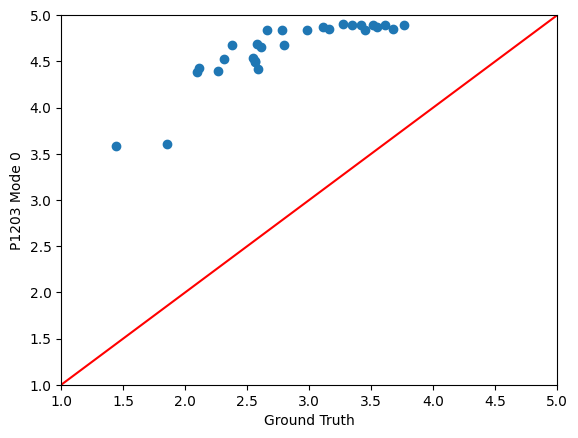

In [206]:
plt.scatter(qoe_ground_truth, p1203_qoe)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("P1203 Mode 0")
plt.savefig("./figures/initial_scatter_plot_BOTH.pdf")

Spearmann
              Ground truth    P.1203
Ground truth      1.000000  0.904053
P.1203            0.904053  1.000000


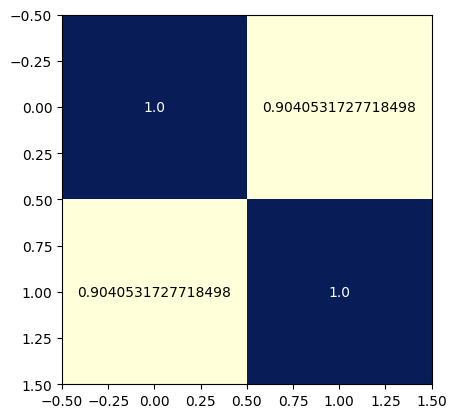

Pearson
              Ground truth    P.1203
Ground truth      1.000000  0.847379
P.1203            0.847379  1.000000


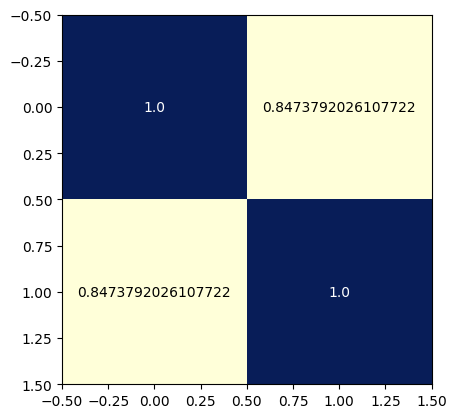

In [207]:
#import seaborn as sns
df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth,
                              'P.1203': p1203_qoe})

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_spearman_1203_1080p_BOTH.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")

plt.savefig("./figures/correlation_pearson_1203_1080p_BOTH.pdf")
plt.show()



# P1203.1 Pv coefficients updates


In [208]:
# Quant(a1, a2, a3, a4) = a1 + a2*ln(a3+ln(bitrate) + ln(br*br/(codRes*fr) + a4))

# MOSq(q1, q2, q3) = q1 + q2*exp(q3*Quant)
# MOSq = max(min(MOSq, 5), 1)

# Dq = max(min(100 - RfromMOS(MOSq), 100), 0)

# MOSfromR:
#     MOS = MOS_min + (MOS_max - MOS_min) * R/100 + R*(R-60)(100-R)*0.000007
#     MOS = min(MOS_max, max(MOS, MOS_min))
#     Calculate MOSfromR, R from 0 -> 100, step 0.25

In [209]:
from functools import lru_cache
from itertools import permutations
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itu_p1203_new import P1203Standalone
from itu_p1203_new import P1203Pv


In [210]:
f = open("./mode0-bothtests.json")
input_data = json.load(f)
# input_data

In [211]:
ground_truth_qoe_df = pd.read_csv('./results/test_scores.csv')
#ground_truth_qoe_df[['object', 'encoder', 'qual', 'dist']] = ground_truth_qoe_df.objects.str.split('_', expand=True)
ground_truth_qoe_df[['object', 'start_qual', 'end_qual', 'dist']] = pd.DataFrame(ground_truth_qoe_df['objects'].apply(split_column).to_list(), index=ground_truth_qoe_df.index)
ground_truth_qoe_df
ground_truth_qoe_df['rate_scaled'] = ground_truth_qoe_df['rate']

ground_truth_qoe_df

,objects,rate,object,start_qual,end_qual,dist,rate_scaled
0,BlueSpin_VPCC_r01_d200,1.0,BlueSpin,r01,r01,d200,1.0
1,FlowerDance_VPCC_r03_d200,2.0,FlowerDance,r03,r03,d200,2.0
2,ReadyForWinter_VPCC_r03_d200,3.0,ReadyForWinter,r03,r03,d200,3.0
3,BlueSpin_VPCC_r05_d200,3.0,BlueSpin,r05,r05,d200,3.0
4,ReadyForWinter_VPCC_r05_d200,3.0,ReadyForWinter,r05,r05,d200,3.0
...,...,...,...,...,...,...,...
1967,Loot_r3_r3_d500,3.0,Loot,r3,r3,d500,3.0
1968,LongDress_r1_r5_d500,2.5,LongDress,r1,r5,d500,2.5
1969,Loot_r1_r5_d500,2.0,Loot,r1,r5,d500,2.0
1970,Loot_r3_r1_d500,2.0,Loot,r3,r1,d500,2.0


In [212]:
ground_truth_qoe_df = ground_truth_qoe_df[['object', 'start_qual', 'end_qual', 'rate_scaled']]
ground_truth_qoe_df

,object,start_qual,end_qual,rate_scaled
0,BlueSpin,r01,r01,1.0
1,FlowerDance,r03,r03,2.0
2,ReadyForWinter,r03,r03,3.0
3,BlueSpin,r05,r05,3.0
4,ReadyForWinter,r05,r05,3.0
...,...,...,...,...
1967,Loot,r3,r3,3.0
1968,LongDress,r1,r5,2.5
1969,Loot,r1,r5,2.0
1970,Loot,r3,r1,2.0


In [213]:
# remove outliers using boxplot method
vpcc_group_columns = ['object', 'start_qual', 'end_qual']
configurations = ground_truth_qoe_df.groupby(vpcc_group_columns)

def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["rate_scaled"]
    q3 = frame.quantile(0.75, numeric_only=True)["rate_scaled"]
    
    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    filtered = (frame["rate_scaled"] >= fence_low) & (frame["rate_scaled"] <= fence_high)
    return frame.loc[filtered]

# for each configuration, filter outliers
df_vpcc_filtered = None
for _, frame in configurations:
    #print(boxplot_outlier_filter(frame))
    df_vpcc_filtered = pd.concat([df_vpcc_filtered, boxplot_outlier_filter(frame)], axis=0)

df_vpcc_filtered = df_vpcc_filtered.reset_index(drop=True)
# groups = df_vpcc_filtered.groupby(vpcc_group_columns)


In [214]:
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

rate_scaled
object      start_qual end_qual                                                   
BlueSpin    r01        r01       (1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, ...
            r02        r02       (2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
            r03        r03       (2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 4.0, 2.0, ...
            r04        r04       (3.0, 4.0, 2.0, 2.0, 5.0, 3.0, 4.0, 5.0, 3.0, ...
            r05        r05       (3.0, 4.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, ...
CasualSquat r01        r01       (1.0, 2.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0, 1.0, ...
            r02        r02       (2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, ...
            r03        r03       (2.0, 3.0, 2.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, ...
            r04        r04       (2.0, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 2.0, ...
            r05        r05       (3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 2.0, 4.0, 3.0, ...
LongDress   r1         r1        (0.5, 3.0, 1.5, 2.5, 2.0, 1.5, 2.0, 1.5, 2.5, ...
                       r3        (0.5, 2.0, 1.0, 3.5, 2.0, 2.5, 2.0, 3.5, 3.0, ...
                       r5        (1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.5, 2.5, 2.5, ...
            r3         r1        (2.0, 2.5, 3.0, 2.0, 2.5, 2.5, 2.5, 3.0, 2.0, ...
                       r3        (1.5, 3.5, 2.5, 3.0, 3.0, 4.5, 2.5, 4.0, 4.0, ...
                       r5        (1.5, 3.0, 2.5, 3.5, 3.0, 5.0, 3.5, 3.0, 3.0, ...
            r5         r1        (2.0, 2.5, 2.0, 3.0, 2.5, 2.0, 1.5, 3.5, 3.0, ...
                       r3        (1.5, 3.5, 3.0, 3.5, 3.0, 3.5, 4.0, 4.0, 3.5, ...
                       r5        (1.5, 3.5, 3.5, 4.0, 3.5, 4.5, 3.5, 4.0, 3.5, ...
Loot        r1         r1        (0.5, 1.5, 2.5, 3.0, 2.0, 2.5, 2.5, 1.5, 3.0, ...
                       r3        (0.5, 3.0, 2.0, 3.0, 2.0, 3.5, 2.0, 3.0, 2.5, ...
                       r5        (1.5, 2.0, 3.0, 3.5, 2.0, 3.0, 1.5, 3.5, 3.0, ...
            r3         r1        (0.5, 2.5, 2.0, 3.0, 2.0, 3.0, 2.0, 2.0, 4.0, ...
                       r3        (1.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4.0, 3.5, 4.5, ...
                       r5        (3.5, 4.0, 3.5, 3.5, 2.5, 3.5, 4.5, 3.5, 3.5, ...
            r5         r1        (0.5, 2.0, 2.5, 4.0, 2.5, 2.0, 2.0, 2.0, 4.0, ...
                       r3        (2.0, 3.5, 2.5, 4.0, 3.5, 5.0, 3.5, 3.0, 4.5, ...
                       r5        (3.5, 4.0, 4.0, 4.0, 4.0, 3.5, 4.0, 3.5, 3.5, ...

In [215]:
# bitratesMbpsNew = {
#     'BlueSpin': {'r01': 1.75, 'r02': 2.29, 'r03': 3.17, 'r04': 7.53, 'r05': 12.62},
#     'CasualSquat':  {'r01': 2.50, 'r02': 3.91, 'r03': 6.66, 'r04': 19.51, 'r05': 31.11},
#     'ReadyForWinter':  {'r01': 1.97, 'r02': 2.58, 'r03': 3.61, 'r04': 9.34, 'r05': 16.59},
#     'FlowerDance':  {'r01': 2.66, 'r02': 4.24, 'r03': 7.12, 'r04': 22.81, 'r05': 39.35},
# }

bitrates_kbps_new = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p

}

# bitratesMbpsOld = {
#     'LongDress': {'r1': 4.64, 'r3': 14.05, 'r5':46.78},
#     'Loot': {'r1': 2.28, 'r3': 5.63, 'r5': 16.68},
#     'RedAndBlack': {'r1': 3.39, 'r3': 7.55, 'r5': 22.9},
#     'Soldier': {'r1': 4.38, 'r3': 11.58, 'r5': 35.29}
# }

bitrates_kbps_old = {
    'LongDress': { 'r1': 45330.51, 'r3': 137209.71, 'r5': 456825.40 },
    'Loot': { 'r1': 22223.74, 'r3': 54941.94, 'r5': 162842.81 },
    'RedAndBlack': { 'r1': 33068.13, 'r3': 73753.55, 'r5': 223673.06 },
    'Soldier': { 'r1': 42745.16, 'r3': 113102.48, 'r5': 344626.97 }
}

resolution_map_old = {
    'r1': '854x480', # old dataset 480p
    'r3': '1280x720', # old dataset 720p
    'r5': '1920x1080' # old dataset 1080p
}

In [216]:
def calculate_p1203(coeffs):
    p1203_results = {
        'object': [],
        'start_qual' : [],
        'end_qual' : [],
        'start_bitrate': [],
        'end_bitrate': [],
        'p1203_qoe': []
    }

    for video in list(bitrates_kbps_old.keys()):
        bitrate_permutations = permutations(list(bitrates_kbps_old[video].values()), 2)
        quality_permutations = permutations(list(bitrates_kbps_old[video].keys()),2)

        bitrates=list(bitrate_permutations)
        qualities = list(quality_permutations)

        for bitrate in list(bitrates_kbps_old[video].values()):
            bitrates.append((bitrate, bitrate))

        for quality in list(bitrates_kbps_old[video].keys()):
            qualities.append((quality, quality))

        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['start_qual'].append(quality[0])
            p1203_results['end_qual'].append(quality[1])
            p1203_results['start_bitrate'].append(bitrate[0])
            p1203_results['end_bitrate'].append(bitrate[1])

            input_data['I13']['segments'][0]['bitrate'] = bitrate[0]
            input_data['I13']['segments'][0]['resolution'] = resolution_map_old[quality[0]]
            input_data['I13']['segments'][1]['bitrate'] = bitrate[1]
            input_data['I13']['segments'][1]['resolution'] = resolution_map_old[quality[1]]

            # the old dataset videos are 30 fps and 10 seconds in sequence length
            input_data['I13']['segments'][0]['fps'] = 30
            input_data['I13']['segments'][1]['fps'] = 30
            input_data['I13']['segments'][0]['duration'] = 5
            input_data['I13']['segments'][1]['duration'] = 5
            input_data['I13']['segments'][1]['start'] = 5

            p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

            #print(video)
            #print(input_data)

    for video in list(bitrates_kbps_new.keys()):   
        bitrates = list(bitrates_kbps_new[video].values())
        qualities = list(bitrates_kbps_new[video].keys())

        for bitrate, quality in zip(bitrates, qualities):
            p1203_results['object'].append(video)
            p1203_results['start_qual'].append(quality)
            p1203_results['end_qual'].append(quality)
            p1203_results['start_bitrate'].append(bitrate)
            p1203_results['end_bitrate'].append(bitrate)

            input_data['I13']['segments'][0]['bitrate'] = bitrate
            input_data['I13']['segments'][0]['resolution'] = resolution_map_new[quality]
            input_data['I13']['segments'][1]['bitrate'] = bitrate
            input_data['I13']['segments'][1]['resolution'] = resolution_map_new[quality]

            # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
            input_data['I13']['segments'][0]['fps'] = 25
            input_data['I13']['segments'][1]['fps'] = 25
            input_data['I13']['segments'][0]['duration'] = 10
            input_data['I13']['segments'][1]['duration'] = 10
            input_data['I13']['segments'][1]['start'] = 10 # make sure to mark the start of the second segment at 10 seconds for new videos

            p1203_results['p1203_qoe'].append(P1203Standalone(input_data).calculate_complete()['O46'])

            #print(video)
            #print(input_data)
    print(p1203_results)
    return p1203_results
    




In [217]:
def calculate_rmse(p1203_results, mos):
    joined_qoe = p1203_results.join(mos)
    rmse_arr = []
    #print("joined_qoe")
    #print(joined_qoe)

    for idx in np.arange(joined_qoe.shape[0]):
        
        #print("joined_qoe.shape[0]")
        #print(joined_qoe.shape[0])
        targets = joined_qoe.iloc[idx,:]['rate_scaled']
        #print("targets")
        #print(targets)
        #print(len(targets))
        predictions = np.full(len(targets), joined_qoe.loc[joined_qoe.index[idx], 'p1203_qoe'])
        #print("predictions")
        #print(predictions)
        #print(len(predictions))
        rmse_arr.append(np.sqrt(np.mean((predictions-targets)**2)))
        #print("rmse_arr")
        #print(rmse_arr)
    
    return np.average(rmse_arr)


In [218]:
from datetime import datetime

_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

# this function isnt being called normally anywhere
def finetune_coeffs():
    min_rmse = sys.float_info.max
    optimized_coeffs = _COEFFS
    optimized_p1203_qoe  =[]

    # for _COEFFS['u1'] in np.arange(50,100):
    #     for _COEFFS['u2'] in np.arange(1):
            # for _COEFFS['t1'] in np.arange(1):
            #     for _COEFFS['t2'] in np.arange(1):
            #         for _COEFFS['t3'] in np.arange(1):
                        # for _COEFFS['q1'] in np.arange(1):
                        #     for _COEFFS['q2'] in np.arange(1):
                        #         for _COEFFS['q3'] in np.arange(1):
    for _COEFFS['mode0']['a1'] in np.arange(1, 15, 0.5): # 0.5 range originally
        for _COEFFS['mode0']['a2'] in np.arange(-5, 0, 0.5): # 0.5 range originally
            for _COEFFS['mode0']['a3'] in np.arange(0, 80, 1): # 1 range originally
                for _COEFFS['mode0']['a4'] in np.arange(0, 5, 0.5): # 0.5 range originally
                    # print(_COEFFS)

                    qoe_p1203_dict = calculate_p1203(_COEFFS)
                    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

                    # Fine tune aka train with BlueSpin and CasualSquat
                    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
                    grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual']).mean()
                    #print("grouped_p1203_qoe")
                    #print(grouped_p1203_qoe)

                    print("timestamp")
                    print(datetime.now())
                    print("COEFFS: " + str(_COEFFS['mode0']['a1']) + " " + str(_COEFFS['mode0']['a2']) + " " + str(_COEFFS['mode0']['a3']) + " " + str(_COEFFS['mode0']['a4']))

                    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
                    print("Calcd RMSE: " + str(rmse))
                    print("Current min RMSE: " + str(min_rmse))
                    if rmse < min_rmse:   
                        print("==> NEW MIN RMSE: " + str(rmse))
                        print("==> MIN RMSE _COEFFS: " + str(_COEFFS))
                        
                        optimized_coeffs = _COEFFS
                        min_rmse = rmse
                        optimized_p1203_qoe = list(grouped_p1203_qoe['p1203_qoe'])

    return optimized_coeffs, optimized_p1203_qoe, min_rmse

In [219]:
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping

# objective function to minimise
def objective_function(trial_coeffs, multiplier=1):
    current_coeffs = _COEFFS
    current_coeffs['mode0']['a1'] = trial_coeffs[0]
    current_coeffs['mode0']['a2'] = trial_coeffs[1]
    current_coeffs['mode0']['a3'] = trial_coeffs[2]
    current_coeffs['mode0']['a4'] = trial_coeffs[3]

    qoe_p1203_dict = calculate_p1203(current_coeffs)
    p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)
    p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
    grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual']).mean()
    print("COEFFS: " + str(current_coeffs['mode0']['a1']) + " " + str(current_coeffs['mode0']['a2']) + " " + str(current_coeffs['mode0']['a3']) + " " + str(current_coeffs['mode0']['a4']))

    rmse = calculate_rmse(grouped_p1203_qoe, ground_truth_qoe_grouped_df)
    print("Calcd RMSE: " + str(rmse))
    #print("Current min RMSE: " + str(min_rmse))
    return rmse

initial_coeffs = [12,-3,41,0]

bounds = [(1,15), (-5, 5), (0, 80), (0, 5)]
#bounds = [(0,100), (0,100), (0,100), (0,100)]
#bounds = [(-100,100), (-100,100), (-100,100), (-100,100)]
#bounds = Bounds(-100,100)

result2 = basinhopping(objective_function, initial_coeffs, minimizer_kwargs={'bounds':bounds, 'method':'L-BFGS-B'})
print("optimised coeffs basinhopping:" + str(result2.x))
print("objective funciton value:" + str(result2.fun))

{'object': ['LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'FlowerDance', 'FlowerDance', 'FlowerDance', 'FlowerDance', 'FlowerDance'], 'start_qual': ['r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r01', 'r02', 'r03', 'r04', 'r05'

In [ ]:
#result = minimize(objective_function, initial_coeffs, method='L-BFGS-B', bounds=bounds)
result = differential_evolution(objective_function, bounds, strategy='rand2bin', disp=True, workers=-1)

print("Optimized coefficients:", str(result.x))
print("Objective function value:", str(result.fun))

/home/shivi/.local/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


{'object': ['LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'LongDress', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'Loot', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'RedAndBlack', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'Soldier', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'BlueSpin', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'CasualSquat', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'ReadyForWinter', 'FlowerDance', 'FlowerDance', 'FlowerDance', 'FlowerDance', 'FlowerDance'], 'start_qual': ['r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r1', 'r1', 'r3', 'r3', 'r5', 'r5', 'r1', 'r3', 'r5', 'r01', 'r02', 'r03', 'r04', 'r05'

In [ ]:
print("Optimized coefficients differential evolution:", result.x)
print("Objective function value  differential evolution:", result.fun)
print("Optimization message  differential evolution:", result.message)
print("optimised coeffs basinhopping:" + result2.x)
print("objective funciton value basinhopping:" + result2.fun)

In [228]:
#optimized_coeffs, p1203_qoe_list, min_rmse =  finetune_coeffs()
#print("timestamp")
#print(datetime.now())
#print("FINAL RESULT")
#print(optimized_coeffs, p1203_qoe_list, min_rmse)

In [229]:
#print(min_rmse)
#print(optimized_coeffs)
#print(ground_truth_qoe_df.groupby(['object', 'qual']).mean()['rate_scaled'])


In [230]:
#==============================================================================================================================
#FOUND THE BEST

In [231]:
ground_truth_qoe_list = list(ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual']).mean()['rate_scaled'])
ground_truth_qoe_list = ground_truth_qoe_list

In [ ]:
#coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}
coeffs = _COEFFS

print(result.x[0])
print(result.x[1])
print(result.x[2])
print(result.x[3])

print(result2.x[0])
print(result2.x[1])
print(result2.x[2])
print(result2.x[3])

coeffs['mode0']['a1'] = result.x[0]
coeffs['mode0']['a2'] = result.x[1]
coeffs['mode0']['a3'] = result.x[2]
coeffs['mode0']['a4'] = result.x[3]
   

#coeffs = optimized_coeffs
print(coeffs)

qoe_p1203_dict = calculate_p1203(coeffs)
p1203_df = pd.DataFrame.from_dict(qoe_p1203_dict)

p1203_df = p1203_df.loc[p1203_df['object'].isin(['BlueSpin', 'CasualSquat', 'LongDress', 'Loot'])]
grouped_p1203_qoe = p1203_df.groupby(['object', 'start_qual', 'end_qual']).mean()
grouped_p1203_qoe

In [ ]:
p1203_qoe_list = list(grouped_p1203_qoe['p1203_qoe'])
plt.scatter(ground_truth_qoe_list, p1203_qoe_list)
plt.plot([1, 5], [1, 5], color = 'red')
plt.axis([1, 5, 1, 5])
plt.xlabel("Ground Truth")
plt.ylabel("Fine-tuned P1203 Mode 0")

In [ ]:
#import seaborn as sns

df_correlation = pd.DataFrame({
    "Ground truth": ground_truth_qoe_list,
    "P.1203": p1203_qoe_list
})

#corr_method = 'spearman'
#corr = df_correlation.corr(method=corr_method)
#sns.heatmap(corr, cmap='YlGnBu', annot = True)
#plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized_BOTH.pdf')
#plt.show()

spear_corr = df_correlation.corr(method = 'spearman') #pearson
print("Spearmann")
print(spear_corr)
print(spear_corr.shape)
print(spear_corr["Ground truth"]["P.1203"])

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(spear_corr, cmap='YlGnBu')

plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_spearman_optimized_BOTH.pdf")
plt.show()

pearson_corr = df_correlation.corr(method = 'pearson') #spearman
print("Pearson")
print(pearson_corr)

#sns.heatmap(corr, cmap='YlGnBu', annot = True)
plt.imshow(pearson_corr, cmap='YlGnBu')

plt.text(0, 0, pearson_corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
plt.text(1, 0, pearson_corr['Ground truth']['P.1203'], ha = "center", va = "center", color = "black")
plt.text(0, 1, pearson_corr['P.1203']['Ground truth'], ha = "center", va = "center", color = "black")
plt.text(1, 1, pearson_corr['P.1203']['P.1203'], ha = "center", va = "center", color = "w")


plt.savefig("./figures/correlation_pearson_optimized_BOTH.pdf")
plt.show()


In [235]:
# corr_method = 'pearson'
# corr = df_correlation.corr(method=corr_method)
# sns.heatmap(corr, cmap='YlGnBu', annot = True)
# plt.savefig('./figures/correlation_heatmap_' + corr_method + '_optimized_BOTH.pdf')
# plt.show()

In [236]:
#==============================================================================================================================
#VALIDATING with ReadyForWinter and FlowerDance

In [ ]:
coeffs = {'u1': 72.61, 'u2': 0.32, 't1': 30.98, 't2': 1.29, 't3': 64.65, 'q1': 4.4, 'q2': -1.5, 'q3': 1.5, 'mode0': {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}, 'mode1': {'a1': 5.00011566, 'a2': -1.19630824, 'a3': 41.3585049, 'a4': 0, 'c0': -0.91562479, 'c1': 0, 'c2': -3.28579526, 'c3': 20.4098663}, 'htv_1': -0.60293, 'htv_2': 2.12382, 'htv_3': -0.36936, 'htv_4': 0.03409}

qoe_p1203_dict = calculate_p1203(coeffs)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
                                # & ((qoe_p1203_df['qual'].isin(['r01']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_validation = qoe_p1203_df.groupby(['object', 'start_qual', 'end_qual']).mean()
qoe_validation

In [ ]:
# Get ground truth qoe for these sequences
ground_truth_qoe_df = df_vpcc_filtered.loc[df_vpcc_filtered['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
ground_truth_qoe_grouped_df = ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual']).aggregate(lambda x: tuple(x))
ground_truth_qoe_grouped_df

In [ ]:
calculate_rmse(qoe_validation, ground_truth_qoe_grouped_df)

In [ ]:
ground_truth_list = list(ground_truth_qoe_df.groupby(['object', 'start_qual', 'end_qual']).mean()['rate_scaled'])
qoe_validation_list = list(qoe_validation['p1203_qoe'])
ground_truth_list

In [ ]:
plt.scatter(ground_truth_list, qoe_validation_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Fine-tuned P1203 Mode 0 - Validation')
plt.show()

In [ ]:
corr_method = 'spearman'
corr_df = pd.DataFrame({
    'Fine-tuned P1203': qoe_validation_list,
    'Ground truth': ground_truth_list
})

corr_methods = ['spearman', 'pearson']

for corr_method in corr_methods:
    corr = corr_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot = True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Fine-tuned P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Fine-tuned P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Fine-tuned P1203']['Fine-tuned P1203'], ha = "center", va = "center", color = "w")

    plt.savefig('./figures/correlation_heatmap_' + corr_method + '_validation_BOTH.pdf')
    plt.title(corr_method)
    plt.show()

In [ ]:
# original P1203
_COEFFS = {
        "u1": 72.61,
        "u2": 0.32,
        "t1": 30.98,
        "t2": 1.29,
        "t3": 64.65,
        "q1": 4.66,
        "q2": -0.07,
        "q3": 4.06,
        "mode0": {
            "a1": 11.9983519,
            "a2": -2.99991847,
            "a3": 41.2475074001,
            "a4": 0.13183165961,
        },
        "mode1": {
            "a1": 5.00011566,
            "a2": -1.19630824,
            "a3": 41.3585049,
            "a4": 0,
            "c0": -0.91562479,
            "c1": 0,
            "c2": -3.28579526,
            "c3": 20.4098663,
        },
        "htv_1": -0.60293,
        "htv_2": 2.12382,
        "htv_3": -0.36936,
        "htv_4": 0.03409,
    }

qoe_p1203_dict = calculate_p1203(_COEFFS)
qoe_p1203_df = pd.DataFrame(qoe_p1203_dict)
qoe_p1203_df = qoe_p1203_df.loc[qoe_p1203_df['object'].isin(['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier'])]
                                #  & 
                                # ((qoe_p1203_df['start_quality'].isin(['r1']) & qoe_p1203_df['end_quality'].isin(['r1'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r3']) & qoe_p1203_df['end_quality'].isin(['r3'])) |
                                #  (qoe_p1203_df['start_quality'].isin(['r5']) & qoe_p1203_df['end_quality'].isin(['r5']))) ]
qoe_original_p1203 = qoe_p1203_df.groupby(['object', 'start_qual', 'end_qual']).mean()
qoe_original_p1203

In [ ]:
print(calculate_rmse(qoe_original_p1203, ground_truth_qoe_grouped_df))
qoe_original_p1203_list = list(qoe_original_p1203['p1203_qoe'])

In [ ]:
plt.scatter(ground_truth_list, qoe_original_p1203_list)
plt.plot([1, 5], [1, 5], color='red')
plt.axis([1, 5, 1, 5])
plt.xlabel('Ground Truth')
plt.ylabel('Original P1203 Mode 0')
plt.show()

In [ ]:
corr_all_df = pd.DataFrame({
    "Ground truth": ground_truth_list,
    # "Fine-tuned P1203": qoe_validation_list,
    "Original P1203": qoe_original_p1203_list
})

corr_methods = ['spearman', 'pearson']
for corr_method in corr_methods:
    corr = corr_all_df.corr(method=corr_method)
    #sns.heatmap(corr, cmap='YlGnBu', annot=True)
    plt.imshow(corr, cmap='YlGnBu')

    plt.text(0, 0, corr['Ground truth']['Ground truth'], ha = "center", va = "center", color = "w")
    plt.text(1, 0, corr['Ground truth']['Original P1203'], ha = "center", va = "center", color = "black")
    plt.text(0, 1, corr['Original P1203']['Ground truth'], ha = "center", va = "center", color = "black")
    plt.text(1, 1, corr['Original P1203']['Original P1203'], ha = "center", va = "center", color = "w")
    
    plt.title(corr_method)
    plt.show()